# Data Preparation

In [95]:
import pandas as pd
import numpy as np


loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object})
client = pd.read_csv('data/client.csv')
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')
trans_dev = pd.read_csv('data/trans_dev.csv', dtype={'date':object})


/tmp/ipykernel_5684/3893857664.py:9: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('data/trans_dev.csv', dtype={'date':object})


There was a row with missing values '?' in the district table for both "no. of commited crimes '95" and "unemploymant rate '95" columns. We needed to find a value for it, either replacing it with median or mean value of the column. To decide between median or mean, we need to analyse symmetry and the outliers of each column.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f588a8ed390>,
 'caps': [<matplotlib.lines.Line2D at 0x7f588ca1faf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f588a8ee200>],
 'medians': [<matplotlib.lines.Line2D at 0x7f588ca1ee60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f588ca1ca00>],
 'means': []}

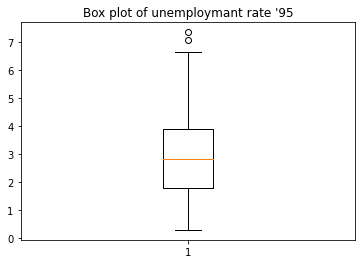

In [96]:
import matplotlib.pyplot as plt

district_clean = district.loc[(district["unemploymant rate '95"] != '?') & (district["no. of commited crimes '95"] != '?')]


plt.title("Box plot of unemploymant rate '95")
plt.boxplot(district_clean["unemploymant rate '95"].astype('float'))


{'whiskers': [<matplotlib.lines.Line2D at 0x7f588aadb340>,
 'caps': [<matplotlib.lines.Line2D at 0x7f588aadb130>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f588aadb700>],
 'medians': [<matplotlib.lines.Line2D at 0x7f588a74d180>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f588a74dff0>],
 'means': []}

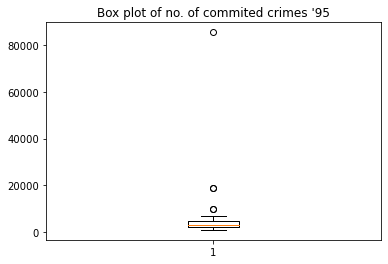

In [97]:
plt.title("Box plot of no. of commited crimes '95")
plt.boxplot(district_clean["no. of commited crimes '95"].astype('int'))

By analysing the box plots, we found out that the data values for "no. of commited crimes '95" and "unemploymant rate '95" are not symmetrical and there are outliers, therefore is would be best to use median instead of mean to replace the cells with '?'

In [98]:

median_unemploymant = district_clean["unemploymant rate '95"].astype(float).median()
median_commited_crimes = district_clean["no. of commited crimes '95"].astype(int).median()


district.loc[district["no. of commited crimes '95"] == '?', "no. of commited crimes '95"] = median_commited_crimes
district.loc[district["unemploymant rate '95"] == '?', "unemploymant rate '95"] = median_unemploymant

# Convert Object Type to Numeric Type
district["unemploymant rate '95"] = pd.to_numeric(district["unemploymant rate '95"])
district["no. of commited crimes '95"] = pd.to_numeric(district["no. of commited crimes '95"])


# Add ratios
# district_df['ratio enterpreneurs'] = district_df['no. of enterpreneurs per 1000 inhabitants'] / 1000
# district_df['ratio of urban inhabitants'] = district_df['ratio of urban inhabitants'] / 100

# district.drop(columns=['name', 'no. of enterpreneurs per 1000 inhabitants', 'no. of inhabitants',
# "unemploymant rate '96", "no. of commited crimes '96",
# "unemploymant rate '95", "no. of commited crimes '95"], inplace=True)

### Extract gender and normalize dates
Since the birth date of each client is represented as YYMMDD when 'Male' or YY(MM+50)DD when 'Female' the gender was extracted as a new feature and the Female client's birth date modified to YYMMDD, the same as Male clients.
Female = False
Male = True

In [99]:
from datetime import datetime, timedelta

def extract_gender(date):
    month = int(str(date)[2:4])
    gender = ''
    if month > 12:
        month -= 50
        gender =False
    else: 
        gender = True
    new_date = str(date)[:2] + str(month).zfill(2) + str(date)[4:]
    return (new_date, gender)

In [100]:
genders = []
dates = []

for birth_number in client['birth_number']:
    (new_date, gender) = extract_gender(birth_number)
    dates.append(new_date)
    genders.append(gender)

client['birth_number'] = dates
client['gender'] = genders

### Remove disponent clients and add to the account's owner entry
Without this chenage more than one client were associated to a single account_id. This was a problem when merging Dispositions Loans tables since this would lead to several entries with the same loan_id and target classes replicated.

In [101]:
disp_owners = disposition.query("type == 'OWNER'")
disp_disponent = disposition.query("type == 'DISPONENT'")

has_disponent = []
for id in disp_owners['account_id']:
    if id in disp_disponent['account_id']:
        has_disponent.append(True)
    else:
        has_disponent.append(False)

disp_owners['has_disponent'] = has_disponent
disp_owners = disp_owners.drop('type', axis=1)
print(disp_owners)

      disp_id  client_id  account_id  has_disponent
0           1          1           1          False
1           2          2           2           True
3           4          4           3          False
5           6          6           4           True
6           7          7           5          False
...       ...        ...         ...            ...
5363    13623      13931       11333          False
5364    13647      13955       11349          False
5366    13660      13968       11359          False
5367    13663      13971       11362          False
5368    13690      13998       11382          False

[4500 rows x 4 columns]


/tmp/ipykernel_5684/1478729136.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disp_owners['has_disponent'] = has_disponent


In [102]:
data = pd.merge(client, disp_owners, left_on="client_id", right_on="client_id", how='inner')
data = pd.merge(loan_dev, data, left_on="account_id", right_on="account_id", how='inner')
data

,loan_id,account_id,date,amount,duration,payments,status,client_id,birth_number,district_id,gender,disp_id,has_disponent
0,5314,1787,930705,96396,12,8033,-1,2166,470722,30,False,2166,False
1,5316,1801,930711,165960,36,4610,1,2181,680722,46,True,2181,False
2,6863,9188,930728,127080,60,2118,1,11314,360602,45,True,11006,False
3,5325,1843,930803,105804,36,2939,1,2235,400420,14,False,2235,False
4,7240,11013,930906,274740,60,4579,1,13539,780907,63,True,13231,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,961212,155616,48,3242,1,11121,710410,72,False,10813,False
324,5625,3189,961215,222180,60,3703,-1,3855,390320,29,True,3855,False
325,6805,8972,961221,45024,48,938,1,11050,570504,70,False,10742,False
326,7233,10963,961225,115812,36,3217,1,13480,530601,16,True,13172,False


### Merge the date of the loan and the birth date of the client resulting on the age of the client at the loan time

In [103]:
def get_datetime(date):
    year = int(str(date)[0:2]) + 1900
    month = int(str(date)[2:4])
    day = int(str(date)[4:])
    return datetime(year, month, day)

def calc_age(birth_date, other_date):
    diff:timedelta = get_datetime(other_date) - get_datetime(birth_date)
    return round(diff.days / 365.25)


In [104]:
data['age_on_loan_request'] = data.apply(lambda x: calc_age(x['birth_number'], x['date']), axis=1)
data.drop('date', inplace=True, axis=1)
data.drop('birth_number', inplace=True, axis=1)
data

,loan_id,account_id,amount,duration,payments,status,client_id,district_id,gender,disp_id,has_disponent,age_on_loan_request
0,5314,1787,96396,12,8033,-1,2166,30,False,2166,False,46
1,5316,1801,165960,36,4610,1,2181,46,True,2181,False,25
2,6863,9188,127080,60,2118,1,11314,45,True,11006,False,57
3,5325,1843,105804,36,2939,1,2235,14,False,2235,False,53
4,7240,11013,274740,60,4579,1,13539,63,True,13231,False,15
...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,11121,72,False,10813,False,26
324,5625,3189,222180,60,3703,-1,3855,29,True,3855,False,58
325,6805,8972,45024,48,938,1,11050,70,False,10742,False,40
326,7233,10963,115812,36,3217,1,13480,16,True,13172,False,44


### Prepare Transaction table

In [105]:
# Drop columns with more than 70% of missing values
trans_dev.dropna(thresh=len(trans_dev) * 0.3, axis=1, inplace=True)
trans_dev

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN
...,...,...,...,...,...,...,...,...
396680,515914,1763,961231,withdrawal,withdrawal in cash,14.6,67769.5,payment for statement
396681,516262,1765,961231,withdrawal,withdrawal in cash,14.6,19708.1,payment for statement
396682,520019,1775,961231,withdrawal,withdrawal in cash,14.6,15944.5,payment for statement
396683,517894,1769,961231,withdrawal,withdrawal in cash,14.6,34679.4,payment for statement


In [106]:
# Replace type 'withdrawal in cash' with 'withdrawal'
trans_dev.replace({'type': 'withdrawal in cash'}, 'withdrawal', inplace=True)

# Replace NaN of operation with mode for each type
credit_operation_mode = trans_dev[trans_dev['type'] == 'credit']['operation'].mode()[0]
withdrawal_operation_mode = trans_dev[trans_dev['type'] == 'withdrawal']['operation'].mode()[0]
trans_dev['operation'] = trans_dev.apply(lambda x: credit_operation_mode if (x['type'] == 'credit' and pd.isnull(x['operation'])) else (withdrawal_operation_mode if (x['type'] == 'withdrawal' and pd.isnull(x['operation'])) else x['operation']), axis=1)


In [107]:
loan_clone = loan_dev.copy()
trans_clone = trans_dev.copy()

loan_clone['date'] = loan_clone['date'].apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
loan_clone['date'] = pd.to_datetime(loan_clone['date'])
trans_clone['date'] = trans_clone['date'].apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
trans_clone['date'] = pd.to_datetime(trans_clone['date'])

loan_trans = pd.merge(loan_clone, trans_clone, left_on='account_id', right_on='account_id', how='left')
loan_trans['date_diff'] = (loan_trans['date_y']-loan_trans['date_x'])/np.timedelta64(1, 'M')
loan_trans['date_diff'] = loan_trans['date_diff'].astype(int)

def agg_func(data):
    credits = data[(data['type'] == 'credit') & (data['operation'] != 'collection from another bank')]
    withdrawals = data[((data['type'] == 'withdrawal') | (data['type'] == 'withdrawal in cash')) & (data['operation'] != 'remittance to another bank')]
    return pd.Series({
        'mensal_credit': (credits['amount_y'].sum() / (credits['date_diff'].iat[-1] - credits['date_diff'].iat[0] + 1)) if credits.shape[0] != 0 else 0, 
        'mensal_withdrawal': (withdrawals['amount_y'].sum() / (withdrawals['date_diff'].iat[-1] - withdrawals['date_diff'].iat[0] + 1)) if withdrawals.shape[0] != 0 else 0,
        'last_balance': data['balance'].iat[-1],
    })
res = loan_trans.groupby(['loan_id']).apply(agg_func)
res = res.reset_index(drop=False)
res['monthly_diff'] = (res['mensal_credit'] - res['mensal_withdrawal']).astype(int)
res = res.drop(['mensal_credit', 'mensal_withdrawal'], axis=1)

res

,loan_id,last_balance,monthly_diff
0,4959,27855.2,-17725
1,4961,15854.0,-18249
2,4973,23703.8,-38325
3,4996,79007.6,6793
4,5002,28015.4,4832
...,...,...,...
323,7271,53259.7,-32379
324,7284,21029.0,1913
325,7304,24704.4,-39110
326,7305,25697.2,-24624


In [108]:
# Merge data with transaction preparation
data = pd.merge(data, res, left_on='loan_id', right_on='loan_id', how='left')
data

,loan_id,account_id,amount,duration,payments,status,client_id,district_id,gender,disp_id,has_disponent,age_on_loan_request,last_balance,monthly_diff
0,5314,1787,96396,12,8033,-1,2166,30,False,2166,False,46,20100.0,5025
1,5316,1801,165960,36,4610,1,2181,46,True,2181,False,25,52208.9,-6096
2,6863,9188,127080,60,2118,1,11314,45,True,11006,False,57,20272.8,-10726
3,5325,1843,105804,36,2939,1,2235,14,False,2235,False,53,34292.7,-13591
4,7240,11013,274740,60,4579,1,13539,63,True,13231,False,15,41142.9,-35661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,11121,72,False,10813,False,26,60694.1,3950
324,5625,3189,222180,60,3703,-1,3855,29,True,3855,False,58,59578.8,2556
325,6805,8972,45024,48,938,1,11050,70,False,10742,False,40,38384.3,5335
326,7233,10963,115812,36,3217,1,13480,16,True,13172,False,44,41878.1,-17


### Discretizations

##### Age on loan request

In [109]:
data['age_on_loan_request'] = pd.cut(x=data['age_on_loan_request'], bins=[0, 19, 29, 39, 49, 59, 69, 79, 99], labels=['0-19', '21-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99'])
data['age_on_loan_request'] = data['age_on_loan_request'].astype(str)
data

,loan_id,account_id,amount,duration,payments,status,client_id,district_id,gender,disp_id,has_disponent,age_on_loan_request,last_balance,monthly_diff
0,5314,1787,96396,12,8033,-1,2166,30,False,2166,False,40-49,20100.0,5025
1,5316,1801,165960,36,4610,1,2181,46,True,2181,False,21-29,52208.9,-6096
2,6863,9188,127080,60,2118,1,11314,45,True,11006,False,50-59,20272.8,-10726
3,5325,1843,105804,36,2939,1,2235,14,False,2235,False,50-59,34292.7,-13591
4,7240,11013,274740,60,4579,1,13539,63,True,13231,False,0-19,41142.9,-35661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,155616,48,3242,1,11121,72,False,10813,False,21-29,60694.1,3950
324,5625,3189,222180,60,3703,-1,3855,29,True,3855,False,50-59,59578.8,2556
325,6805,8972,45024,48,938,1,11050,70,False,10742,False,40-49,38384.3,5335
326,7233,10963,115812,36,3217,1,13480,16,True,13172,False,40-49,41878.1,-17


### Save Data

In [110]:
data.to_csv('data_processed/data.csv', index=False)